In [2]:
import numpy as np
import numpy.linalg as linalg
import matplotlib.pyplot as plt
from pprint import pprint
from MyPolynom import MyPolynom
import time

LEFT = 0.5
RIGHT = 1.5

ort_base = None

def get_exec_time(func):
    def print_time_of_func(*args, **kwargs):
        start_time = time.time()
        func(*args, **kwargs)
        print(f"| Exec time: {time.time() - start_time}")

    return print_time_of_func

def function(x):
    return (1 + np.abs(np.log(x))) / (1 + 25 * x * x)

def calculate_integral_by_simpson_method(x, f, a, b, N):
    f_x, h = f(x), (b - a) / N
    return h / 3 * (f_x[0] + 4 * np.sum(f_x[1:N:2]) + 2 * np.sum(f_x[2:N - 1:2]) + f_x[-1])

def calculate_integral_by_trapezoid_method(x, f, a, b, N):
    f_x, h = f(x), (b - a) / N
    return h * (0.5 * (f_x[0] + f_x[-1]) + np.sum(f_x[1:-1]))

def calculate_coefficients_for_polynom(a, b, degree_polynom, N, integrate_method=calculate_integral_by_trapezoid_method):
    start = time.time()
    matrix_of_system = np.zeros((degree_polynom + 1, degree_polynom + 1))
    joined_vector = np.zeros(degree_polynom + 1)
    if integrate_method is calculate_integral_by_simpson_method:
        N += N % 2
    sample_x = np.linspace(a, b, N + 1)
    for i in range(degree_polynom + 1):
        for j in range(degree_polynom + 1):
            matrix_of_system[i][j] = integrate_method(sample_x, lambda x: np.pow(x, i) * np.pow(x, j), a, b, N)
        joined_vector[i] = integrate_method(sample_x, lambda x: function(x) * np.pow(x, i), a, b, N)
    coefficients = np.linalg.solve(matrix_of_system, joined_vector)
    print(f"Time exec for standart basis: {time.time() - start} and for {"symp." if integrate_method is calculate_integral_by_simpson_method else "trapz."} method")
    return coefficients

def calculate_polynom_by_coefficients(x_point, coefficients):
    return sum([coefficients[i] * np.pow(x_point, i) for i in range(len(coefficients))])

def projection(sample_x, f_a, f_b, a, b, degree_polynom, N, integrate_method):
    return f_b * MyPolynom([integrate_method(sample_x, (f_a * f_b).get_lambda, a, b, N) / integrate_method(sample_x, (f_b * f_b).get_lambda, a, b, N)])

def init_ort_base(degree_polynom, N, integrate_method=calculate_integral_by_simpson_method):
    global ort_base
    integrate_method = calculate_integral_by_trapezoid_method if integrate_method is calculate_integral_by_trapezoid_method else calculate_integral_by_simpson_method
    if integrate_method is calculate_integral_by_simpson_method:
        N += N % 2
    sample_x = np.linspace(LEFT, RIGHT, N + 1)
    ort_base = [None] * (degree_polynom + 1)
    ort_base[0] = MyPolynom([1])
    for i in range(1, degree_polynom + 1):
        sub_proj = MyPolynom([0])
        for j in range(i):
            sub_proj = sub_proj + projection(sample_x, MyPolynom([0] * i + [i]), ort_base[j], LEFT, RIGHT, degree_polynom, N, integrate_method)
        ort_base[i] = MyPolynom([0] * i + [i]) - sub_proj

def calculate_coefficients_for_polynom_with_ort_base(a, b, degree_polynom, N, integrate_method=calculate_integral_by_trapezoid_method):
    start = time.time()
    coefficients = np.zeros(degree_polynom + 1)
    integrate_method = calculate_integral_by_trapezoid_method if integrate_method is calculate_integral_by_trapezoid_method else calculate_integral_by_simpson_method
    if integrate_method is calculate_integral_by_simpson_method:
        N += N % 2
    sample_x = np.linspace(a, b, N + 1)
    for i in range(degree_polynom + 1):
        coefficients[i] =  integrate_method(sample_x, lambda x: function(x) * ort_base[i].get_value(x), a, b, N) / integrate_method(sample_x, lambda x: ort_base[i].get_value(x) * ort_base[i].get_value(x), a, b, N)
    print(f"Time exec for ort: {time.time() - start}")
    return coefficients

def calculate_polynom_by_ort_coefficients(x_point, coefficients):
    return sum([coefficients[i] * ort_base[i].get_value(x_point) for i in range(len(coefficients))])

def test():
    init_ort_base(5, 10000)
    print(ort_base)
    for i in ort_base:
        print(i)
    print(calculate_coefficients_for_polynom_with_ort_base(LEFT, RIGHT, 5, 10000))
    

def main(degree, N):
    # degree = 3
    # N = 10 * (degree + 1) ** 2
    # N = 10
    # N = 10
    init_ort_base(degree, N)
    # print(*ort_base)
    coeffs1 = calculate_coefficients_for_polynom(LEFT, RIGHT, degree, N)
    coeffs2 = calculate_coefficients_for_polynom(LEFT, RIGHT, degree, N, calculate_integral_by_simpson_method)
    # coeffs3 = calculate_coefficients_for_polynom_with_ort_base(LEFT, RIGHT, degree, N)
    # print(coeffs1, coeffs2, coeffs3)
    sample = np.linspace(LEFT, RIGHT, N)
    f_sample = function(sample)
    fig, ax = plt.subplots(figsize=(20, 9))
    ax.plot(sample, f_sample, 'o', color='black', linewidth=1)
    ax.plot(sample, f_sample, color='r', linewidth=2, label='функция')
    ax.plot(sample, list(map(lambda x: calculate_polynom_by_coefficients(x, coeffs2), sample)), '--', color='g',
            linewidth=4, label='Метод Симпсона')
    # ax.plot(sample, list(map(lambda x: calculate_polynom_by_coefficients(x, coeffs2), sample)), 'o', color='g')
    ax.plot(sample, list(map(lambda x: calculate_polynom_by_coefficients(x, coeffs1), sample)), '--', color='b',
            linewidth=2, label='Метод трапеций')
    # ax.plot(sample, list(map(lambda x: calculate_polynom_by_coefficients(x, coeffs1), sample)), 'o', color='b')
    # ax.plot(sample, list(map(lambda x: calculate_polynom_by_ort_coefficients(x, coeffs3), sample)), '--', color='m',
    #          linewidth=2, label='Ортогональный базис')
    # ax.plot(sample, list(map(lambda x: calculate_polynom_by_coefficients(x, coeffs1), sample)), 'o', color='m')
    ax.set_xlabel('x label')
    ax.set_ylabel('y label')
    plt.grid()
    # plt.ylim(Y_LIM_DOWN, Y_LIM_UP)
    plt.legend()
    plt.show()

Time exec for standart basis: 0.0003407001495361328 and for trapz. method
Time exec for standart basis: 0.0003542900085449219 and for symp. method


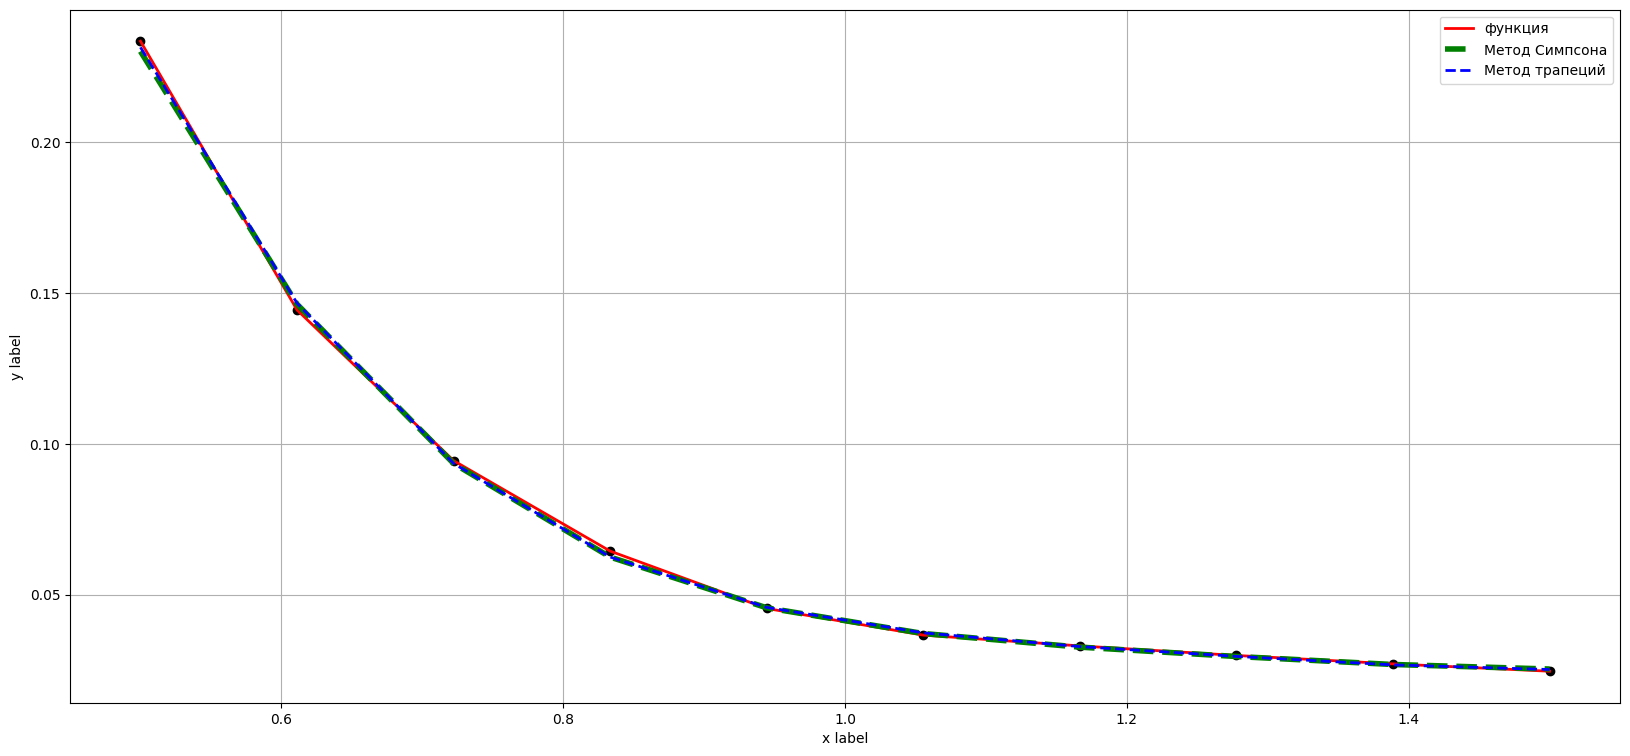

In [3]:
main(4, 10)

Time exec for standart basis: 0.00026297569274902344 and for trapz. method
Time exec for standart basis: 0.00029397010803222656 and for symp. method


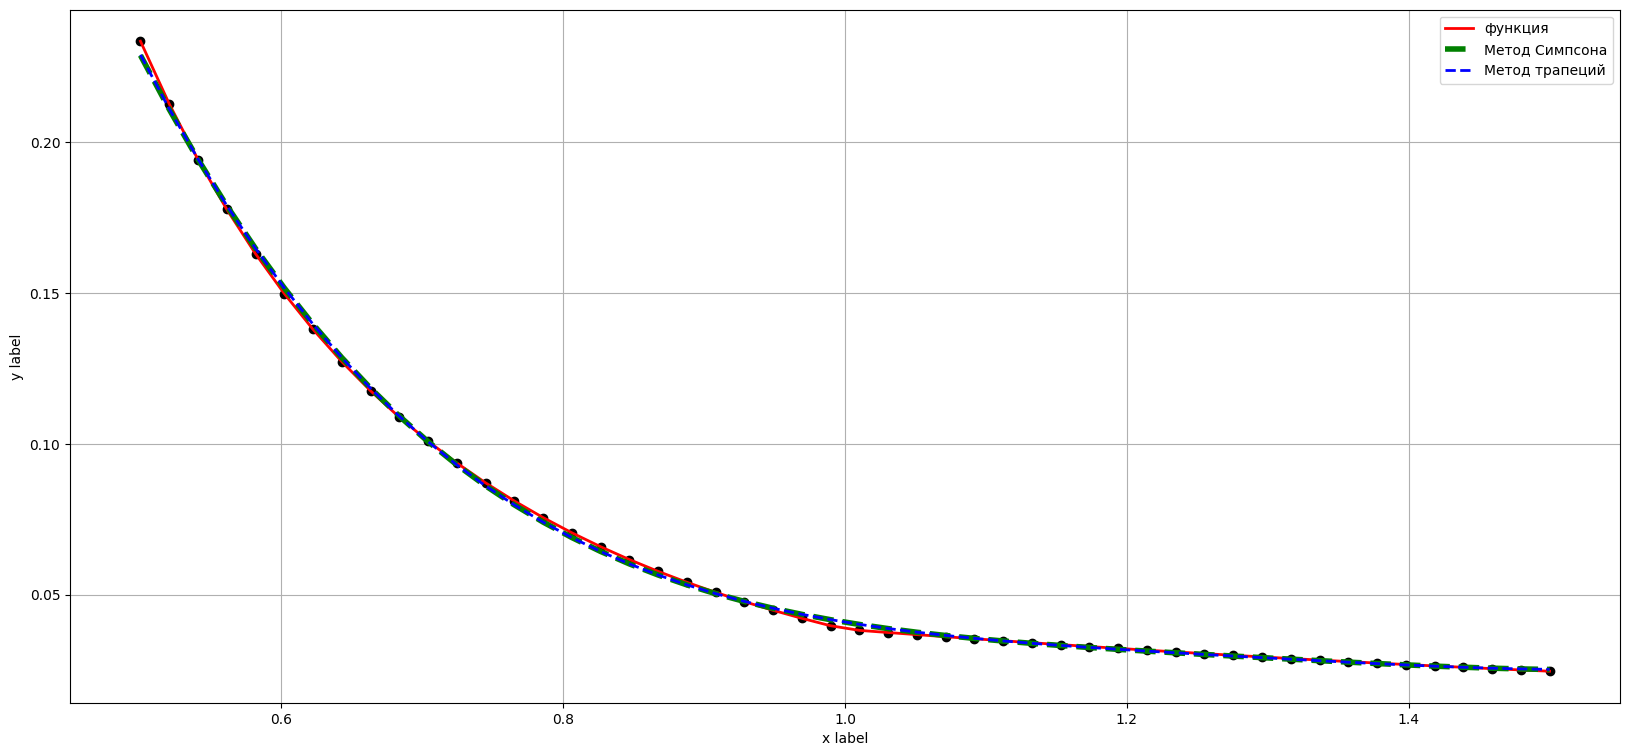

In [4]:
main(4, 50)

Time exec for standart basis: 0.0005466938018798828 and for trapz. method
Time exec for standart basis: 0.0006811618804931641 and for symp. method


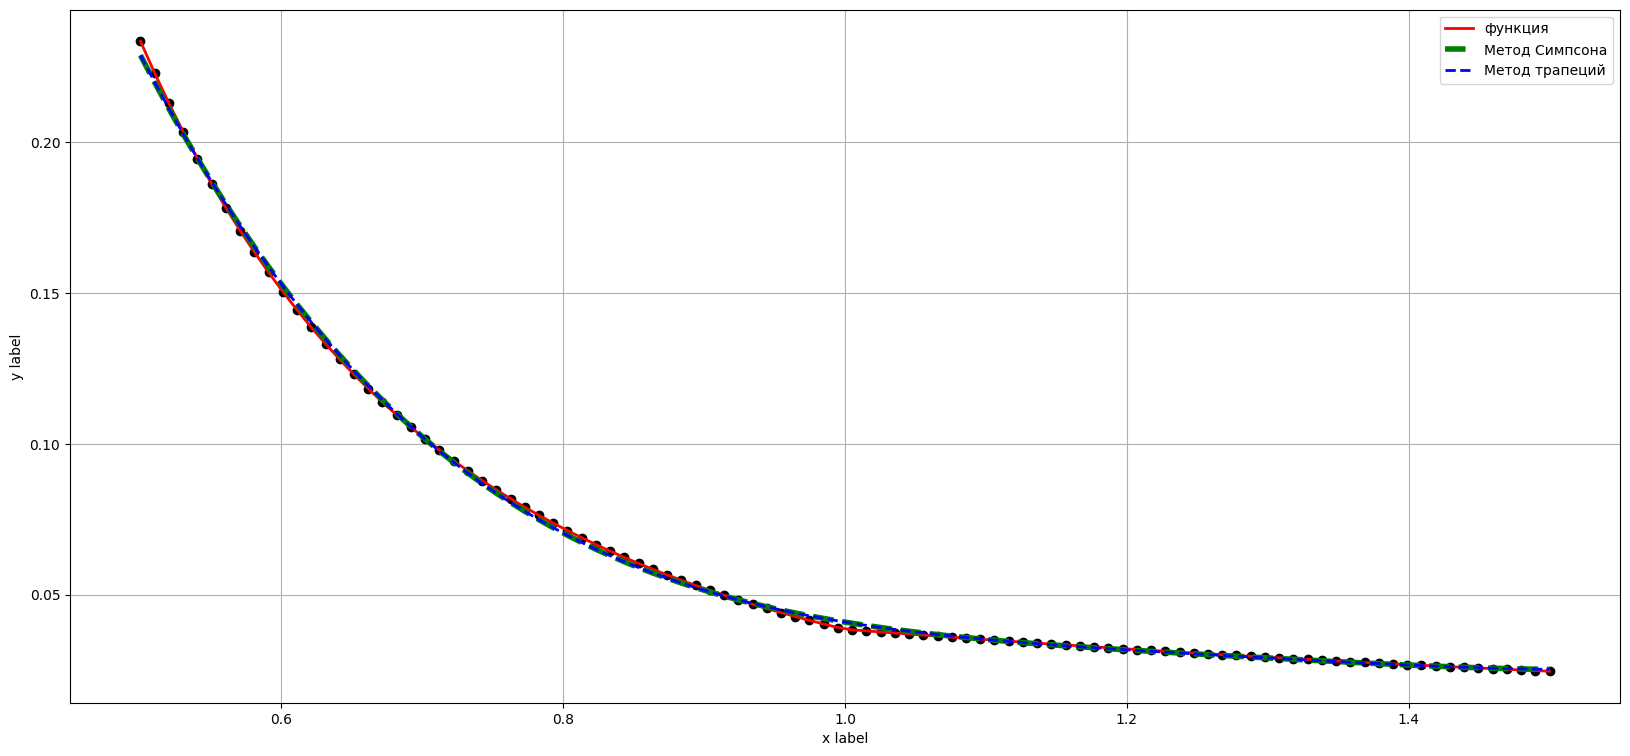

In [5]:
main(4, 100)

Time exec for standart basis: 0.001344442367553711 and for trapz. method
Time exec for standart basis: 0.0018069744110107422 and for symp. method


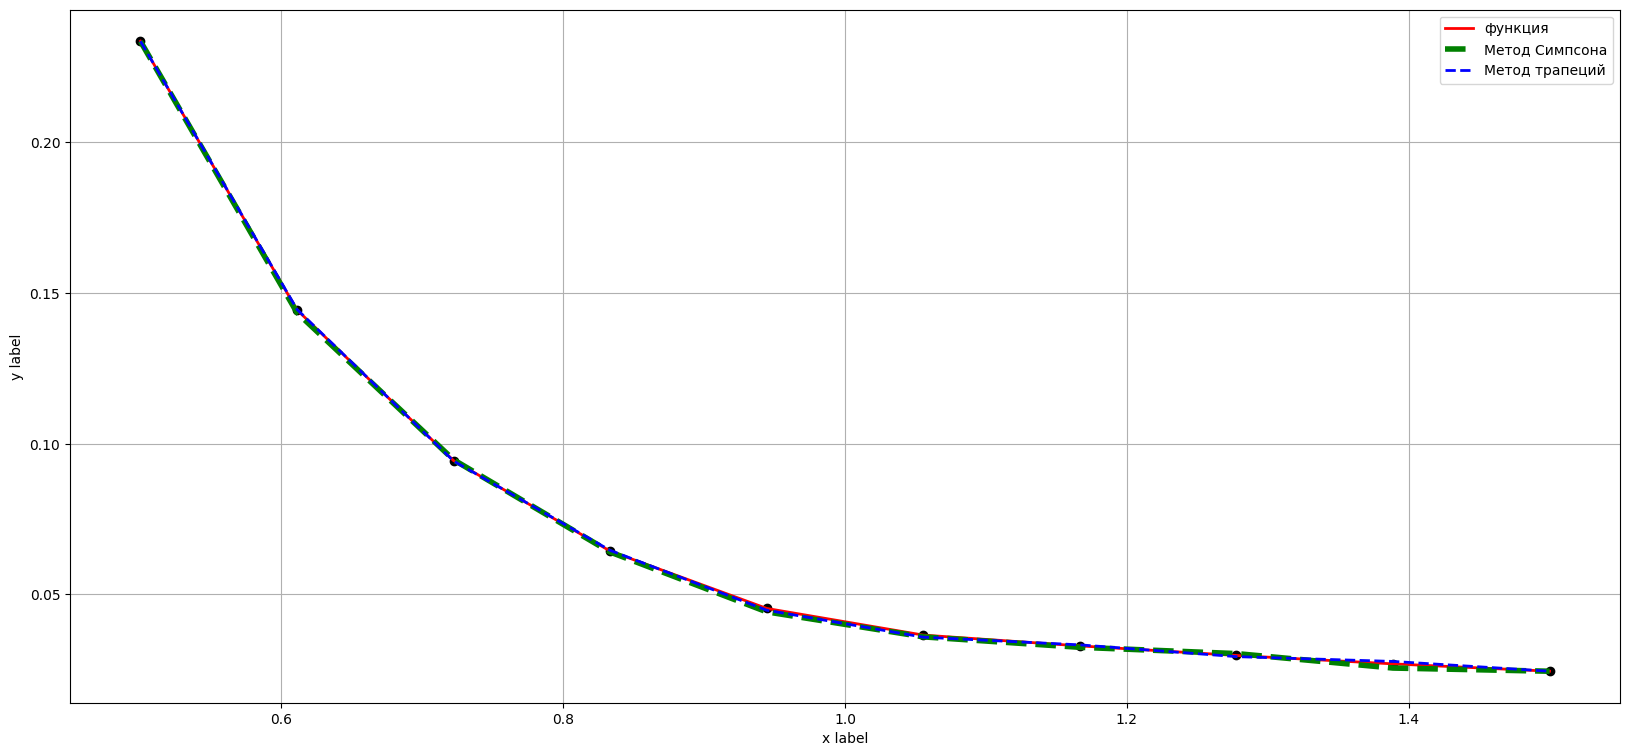

Time exec for standart basis: 0.0017008781433105469 and for trapz. method
Time exec for standart basis: 0.002303600311279297 and for symp. method


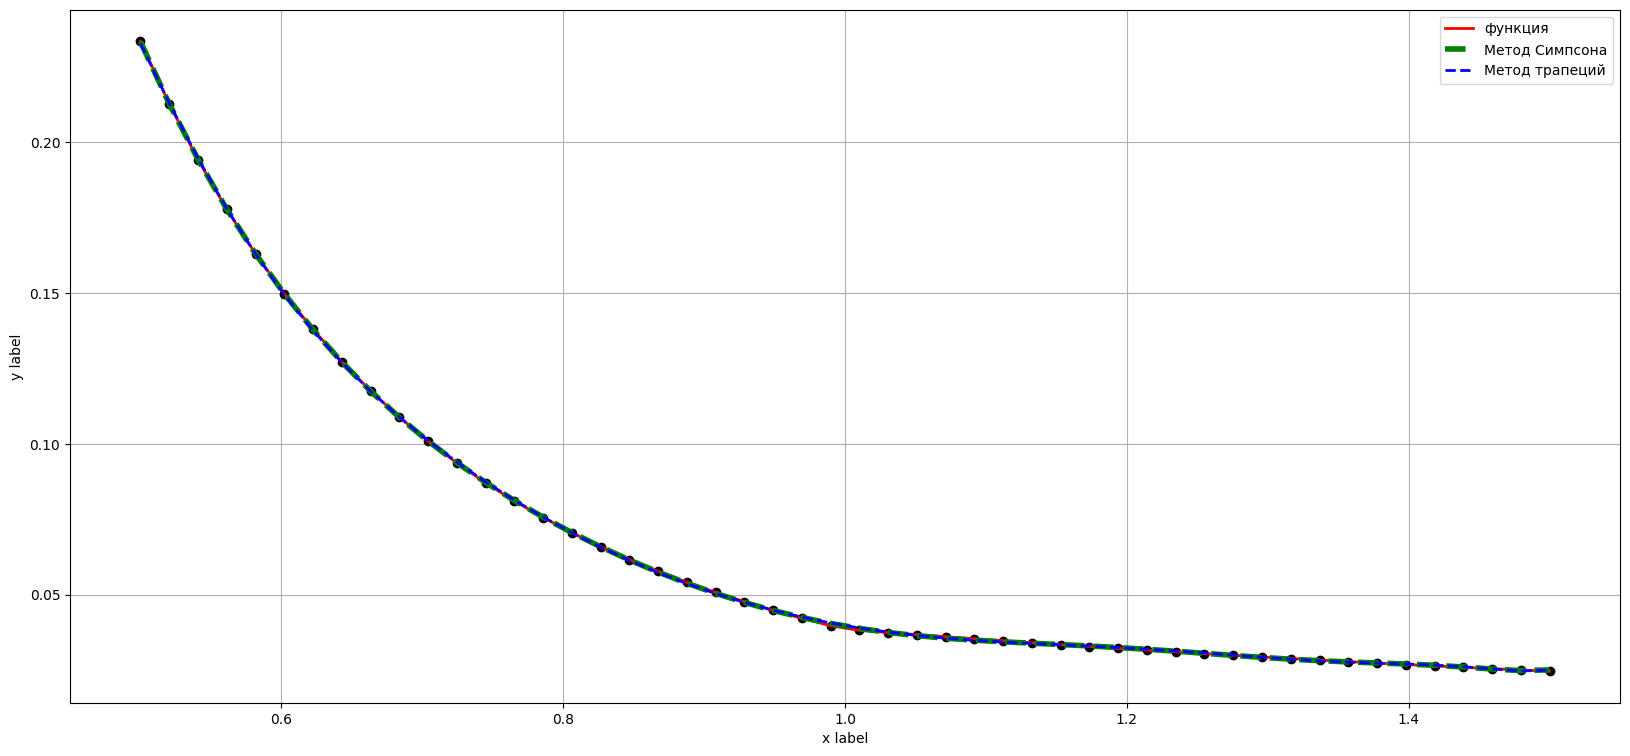

Time exec for standart basis: 0.0020227432250976562 and for trapz. method
Time exec for standart basis: 0.0028243064880371094 and for symp. method


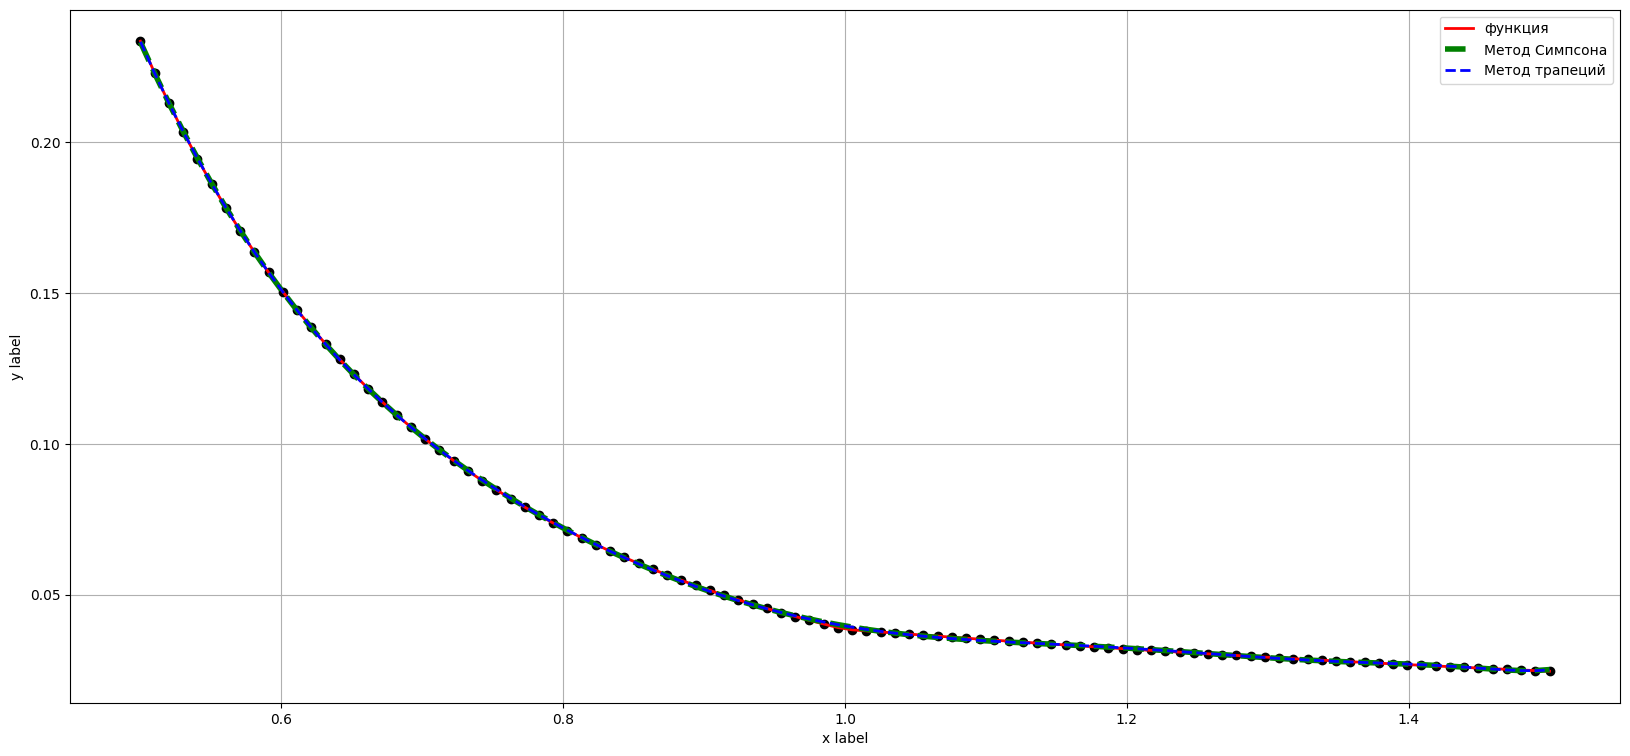

In [6]:
main(15, 10)
main(15, 50)
main(15, 100)

Time exec for standart basis: 0.013750076293945312 and for trapz. method
Time exec for standart basis: 0.017987966537475586 and for symp. method


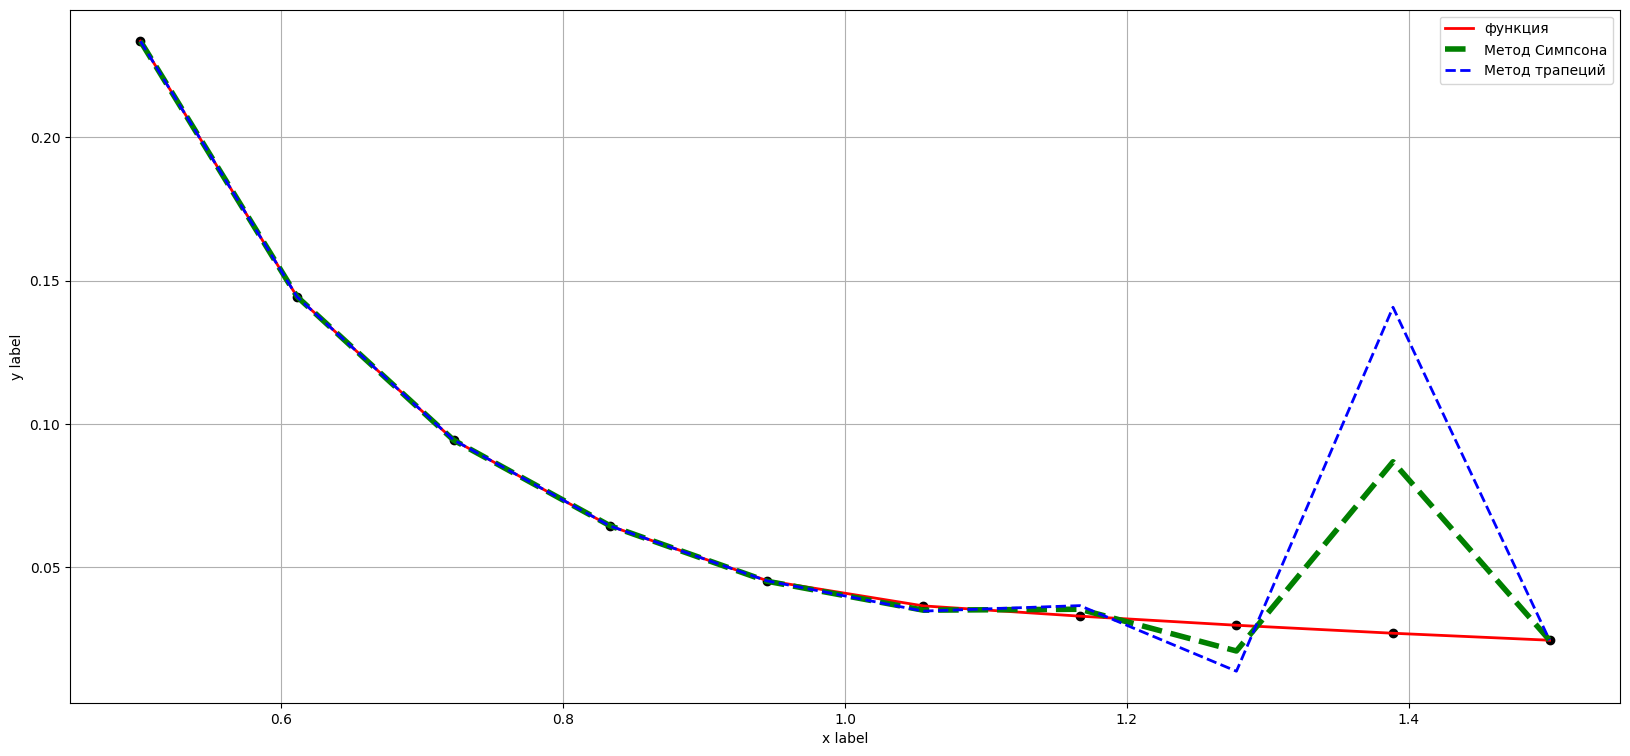

Time exec for standart basis: 0.02067422866821289 and for trapz. method
Time exec for standart basis: 0.02343273162841797 and for symp. method


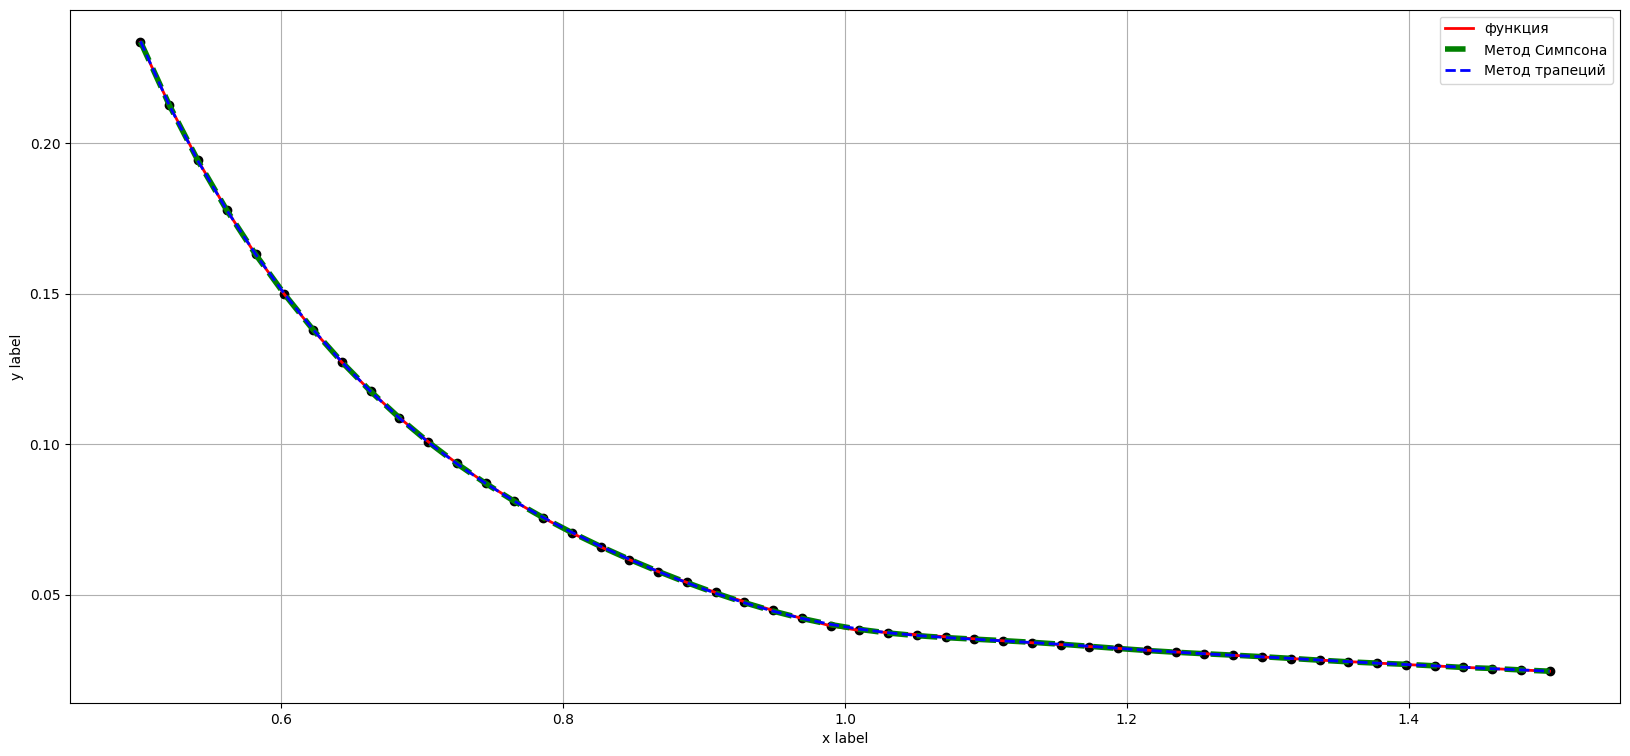

Time exec for standart basis: 0.01940608024597168 and for trapz. method
Time exec for standart basis: 0.024733781814575195 and for symp. method


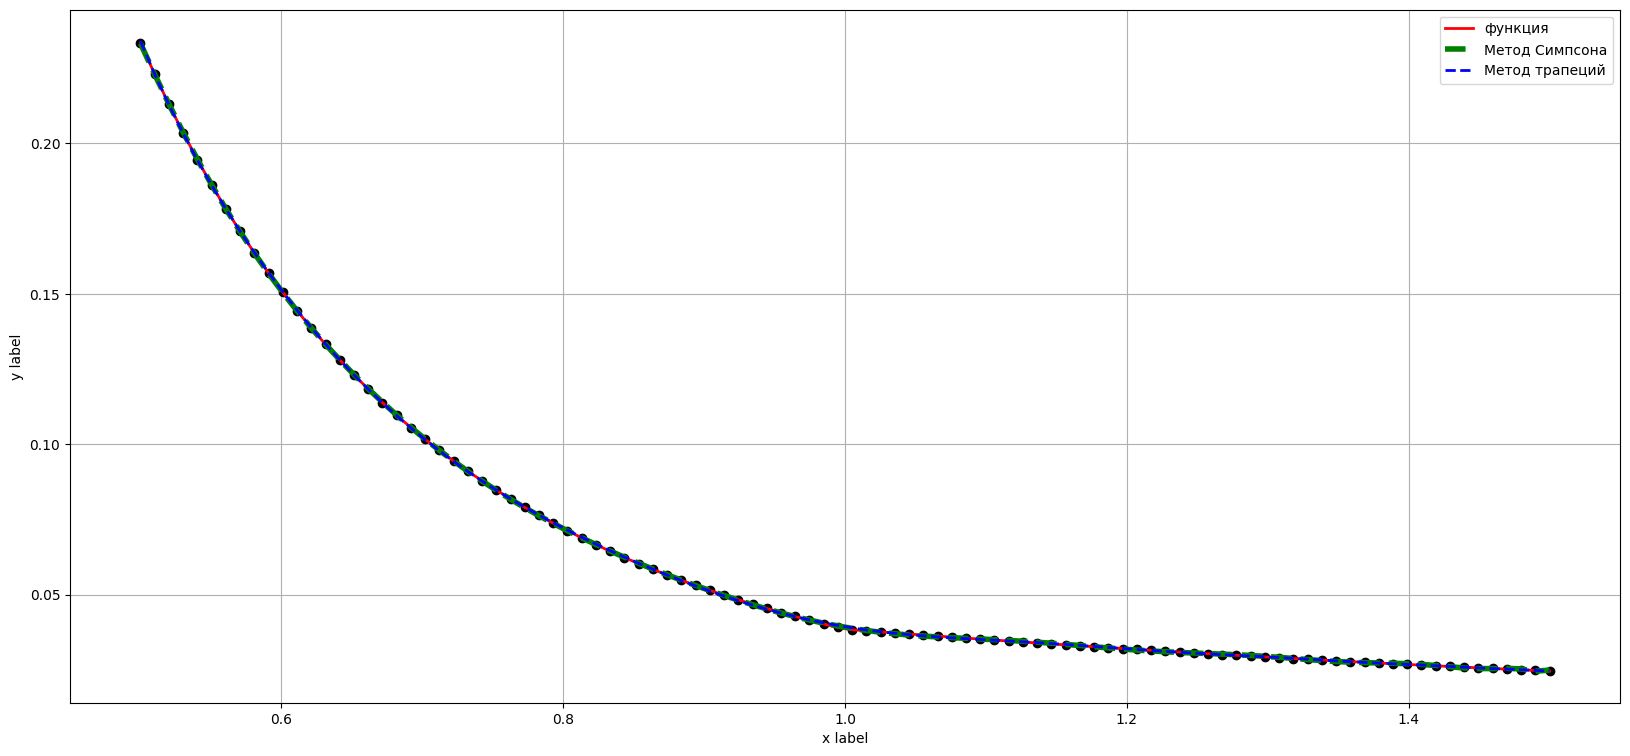

In [7]:
main(50, 10)
main(50, 50)
main(50, 100)

In [15]:
import numpy as np
import numpy.linalg as linalg
import matplotlib.pyplot as plt
from pprint import pprint
from MyPolynom import MyPolynom
import time

LEFT = 0.5
RIGHT = 1.5

ort_base = None

def get_exec_time(func):
    def print_time_of_func(*args, **kwargs):
        start_time = time.time()
        func(*args, **kwargs)
        print(f"| Exec time: {time.time() - start_time}")

    return print_time_of_func

def function(x):
    return (1 + np.abs(np.log(x))) / (1 + 25 * x * x)

def calculate_integral_by_simpson_method(x, f, a, b, N):
    f_x, h = f(x), (b - a) / N
    return h / 3 * (f_x[0] + 4 * np.sum(f_x[1:N:2]) + 2 * np.sum(f_x[2:N - 1:2]) + f_x[-1])

def calculate_integral_by_trapezoid_method(x, f, a, b, N):
    f_x, h = f(x), (b - a) / N
    return h * (0.5 * (f_x[0] + f_x[-1]) + np.sum(f_x[1:-1]))

def calculate_coefficients_for_polynom(a, b, degree_polynom, N, integrate_method=calculate_integral_by_trapezoid_method):
    start = time.time()
    matrix_of_system = np.zeros((degree_polynom + 1, degree_polynom + 1))
    joined_vector = np.zeros(degree_polynom + 1)
    if integrate_method is calculate_integral_by_simpson_method:
        N += N % 2
    sample_x = np.linspace(a, b, N + 1)
    for i in range(degree_polynom + 1):
        for j in range(degree_polynom + 1):
            matrix_of_system[i][j] = integrate_method(sample_x, lambda x: np.pow(x, i) * np.pow(x, j), a, b, N)
        joined_vector[i] = integrate_method(sample_x, lambda x: function(x) * np.pow(x, i), a, b, N)
    coefficients = np.linalg.solve(matrix_of_system, joined_vector)
    print(f"Time exec for standart basis: {time.time() - start} and for {"symp." if integrate_method is calculate_integral_by_simpson_method else "trapz."} method")
    return coefficients

def calculate_polynom_by_coefficients(x_point, coefficients):
    return sum([coefficients[i] * np.pow(x_point, i) for i in range(len(coefficients))])

def projection(sample_x, f_a, f_b, a, b, degree_polynom, N, integrate_method):
    return f_b * MyPolynom([integrate_method(sample_x, (f_a * f_b).get_lambda, a, b, N) / integrate_method(sample_x, (f_b * f_b).get_lambda, a, b, N)])

def init_ort_base(degree_polynom, N, integrate_method=calculate_integral_by_simpson_method):
    global ort_base
    integrate_method = calculate_integral_by_trapezoid_method if integrate_method is calculate_integral_by_trapezoid_method else calculate_integral_by_simpson_method
    if integrate_method is calculate_integral_by_simpson_method:
        N += N % 2
    sample_x = np.linspace(LEFT, RIGHT, N + 1)
    ort_base = [None] * (degree_polynom + 1)
    ort_base[0] = MyPolynom([1])
    for i in range(1, degree_polynom + 1):
        sub_proj = MyPolynom([0])
        for j in range(i):
            sub_proj = sub_proj + projection(sample_x, MyPolynom([0] * i + [i]), ort_base[j], LEFT, RIGHT, degree_polynom, N, integrate_method)
        ort_base[i] = MyPolynom([0] * i + [i]) - sub_proj

def calculate_coefficients_for_polynom_with_ort_base(a, b, degree_polynom, N, integrate_method=calculate_integral_by_trapezoid_method):
    start = time.time()
    coefficients = np.zeros(degree_polynom + 1)
    integrate_method = calculate_integral_by_trapezoid_method if integrate_method is calculate_integral_by_trapezoid_method else calculate_integral_by_simpson_method
    if integrate_method is calculate_integral_by_simpson_method:
        N += N % 2
    sample_x = np.linspace(a, b, N + 1)
    for i in range(degree_polynom + 1):
        coefficients[i] =  integrate_method(sample_x, lambda x: function(x) * ort_base[i].get_value(x), a, b, N) / integrate_method(sample_x, lambda x: ort_base[i].get_value(x) * ort_base[i].get_value(x), a, b, N)
    print(f"Time exec for ort: {time.time() - start} by {'sym' if integrate_method is calculate_integral_by_simpson_method else 'trap'}")
    return coefficients

def calculate_polynom_by_ort_coefficients(x_point, coefficients):
    return sum([coefficients[i] * ort_base[i].get_value(x_point) for i in range(len(coefficients))])

def test():
    init_ort_base(5, 10000)
    print(ort_base)
    for i in ort_base:
        print(i)
    print(calculate_coefficients_for_polynom_with_ort_base(LEFT, RIGHT, 5, 10000))
    

def main2(degree, N):
    # degree = 3
    # N = 10 * (degree + 1) ** 2
    # N = 10
    # N = 10
    init_ort_base(degree, N)
    # print(*ort_base)
    coeffs1 = calculate_coefficients_for_polynom_with_ort_base(LEFT, RIGHT, degree, N)
    coeffs2 = calculate_coefficients_for_polynom_with_ort_base(LEFT, RIGHT, degree, N, calculate_integral_by_simpson_method)
    # coeffs3 = calculate_coefficients_for_polynom_with_ort_base(LEFT, RIGHT, degree, N)
    # print(coeffs1, coeffs2, coeffs3)
    sample = np.linspace(LEFT, RIGHT, N)
    f_sample = function(sample)
    fig, ax = plt.subplots(figsize=(20, 9))
    ax.plot(sample, f_sample, 'o', color='black', linewidth=1)
    ax.plot(sample, f_sample, color='r', linewidth=2, label='функция')
    ax.plot(sample, list(map(lambda x: calculate_polynom_by_ort_coefficients(x, coeffs2), sample)), '--', color='g',
            linewidth=4, label='Метод Симпсона орт.')
    # ax.plot(sample, list(map(lambda x: calculate_polynom_by_coefficients(x, coeffs2), sample)), 'o', color='g')
    ax.plot(sample, list(map(lambda x: calculate_polynom_by_ort_coefficients(x, coeffs1), sample)), '--', color='b',
            linewidth=2, label='Метод трапеций орт.')
    # ax.plot(sample, list(map(lambda x: calculate_polynom_by_coefficients(x, coeffs1), sample)), 'o', color='b')
    # ax.plot(sample, list(map(lambda x: calculate_polynom_by_ort_coefficients(x, coeffs3), sample)), '--', color='m',
    #          linewidth=2, label='Ортогональный базис')
    # ax.plot(sample, list(map(lambda x: calculate_polynom_by_coefficients(x, coeffs1), sample)), 'o', color='m')
    ax.set_xlabel('x label')
    ax.set_ylabel('y label')
    plt.grid()
    # plt.ylim(Y_LIM_DOWN, Y_LIM_UP)
    plt.legend()
    plt.show()

Time exec for ort: 0.00021266937255859375 by trap
Time exec for ort: 0.0002295970916748047 by sym


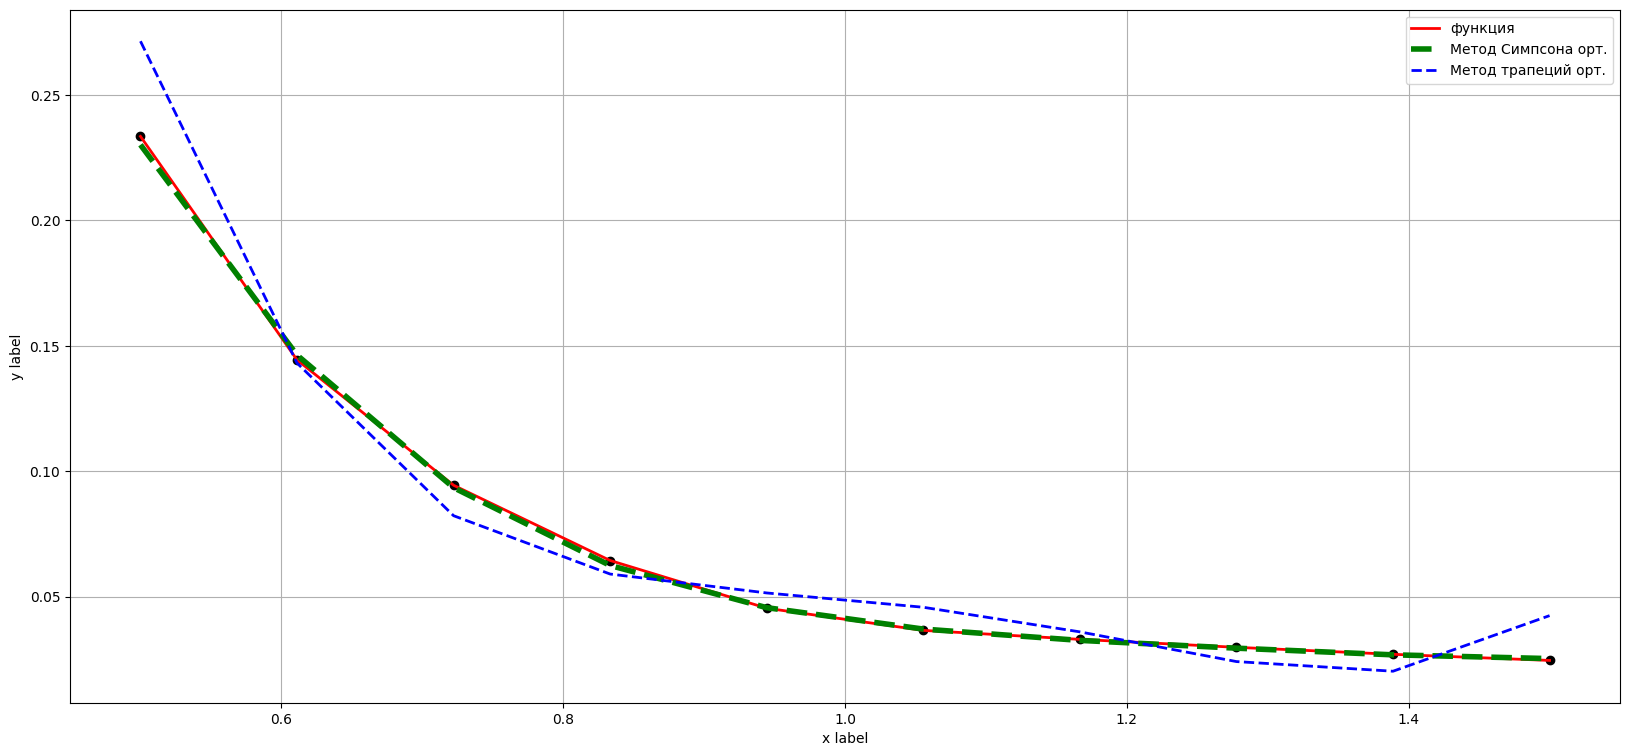

Time exec for ort: 0.000186920166015625 by trap
Time exec for ort: 0.0001995563507080078 by sym


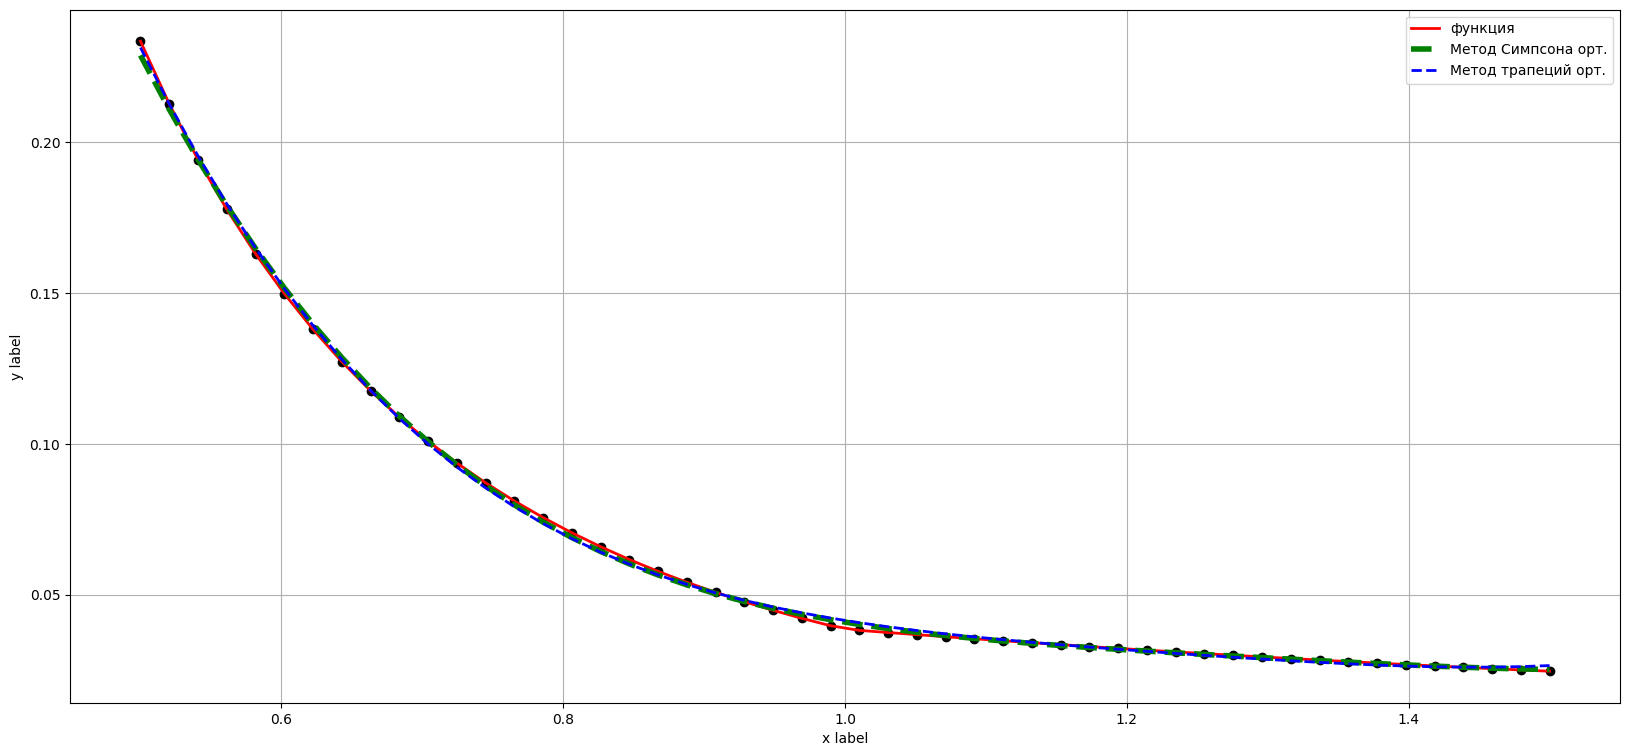

Time exec for ort: 0.00019550323486328125 by trap
Time exec for ort: 0.00021076202392578125 by sym


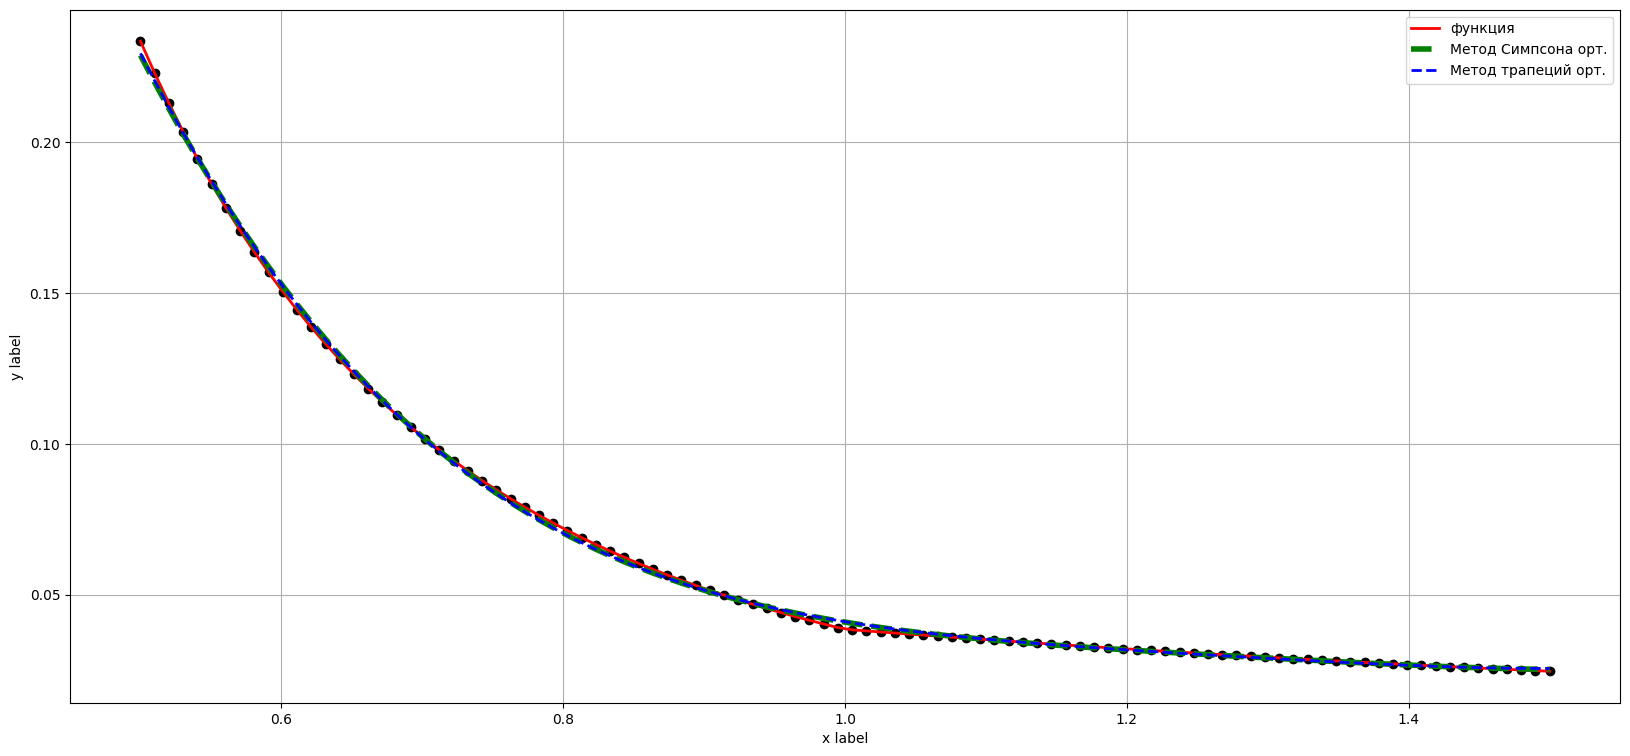

In [16]:
main2(4, 10)
main2(4, 50)
main2(4, 100)

Time exec for ort: 0.0009431838989257812 by trap
Time exec for ort: 0.0009772777557373047 by sym


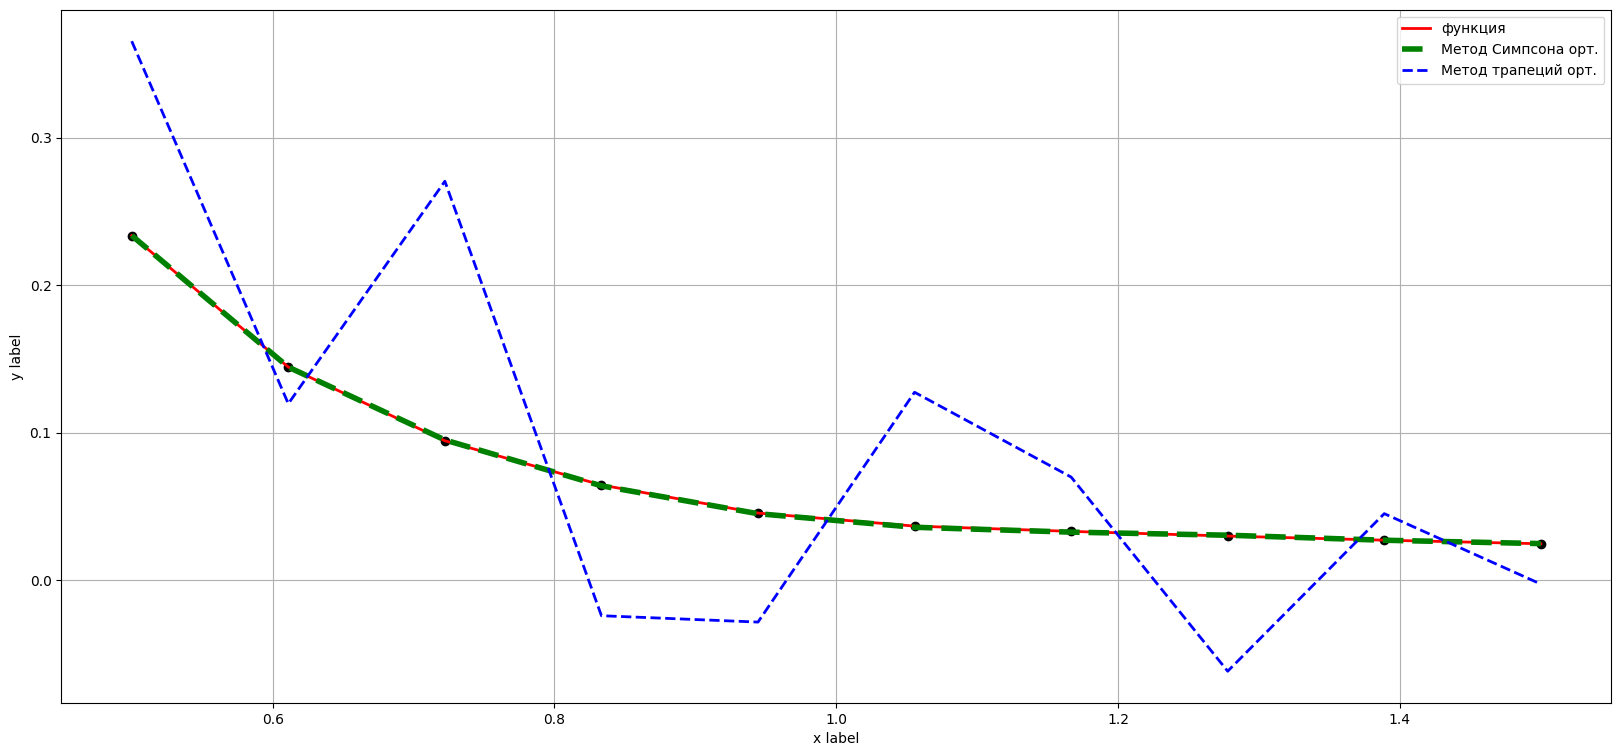

Time exec for ort: 0.0012400150299072266 by trap
Time exec for ort: 0.001222848892211914 by sym


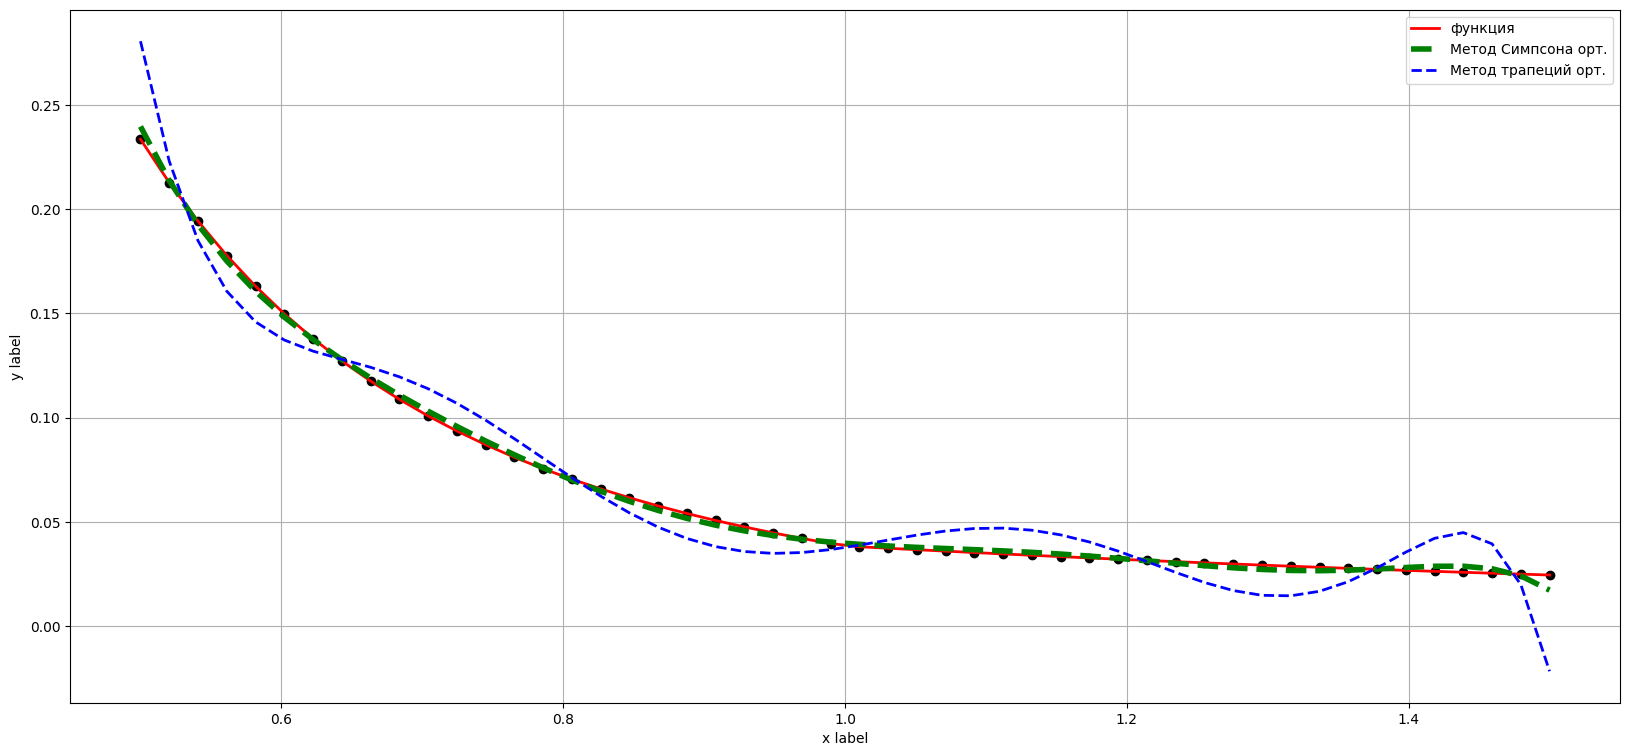

Time exec for ort: 0.0014371871948242188 by trap
Time exec for ort: 0.0014801025390625 by sym


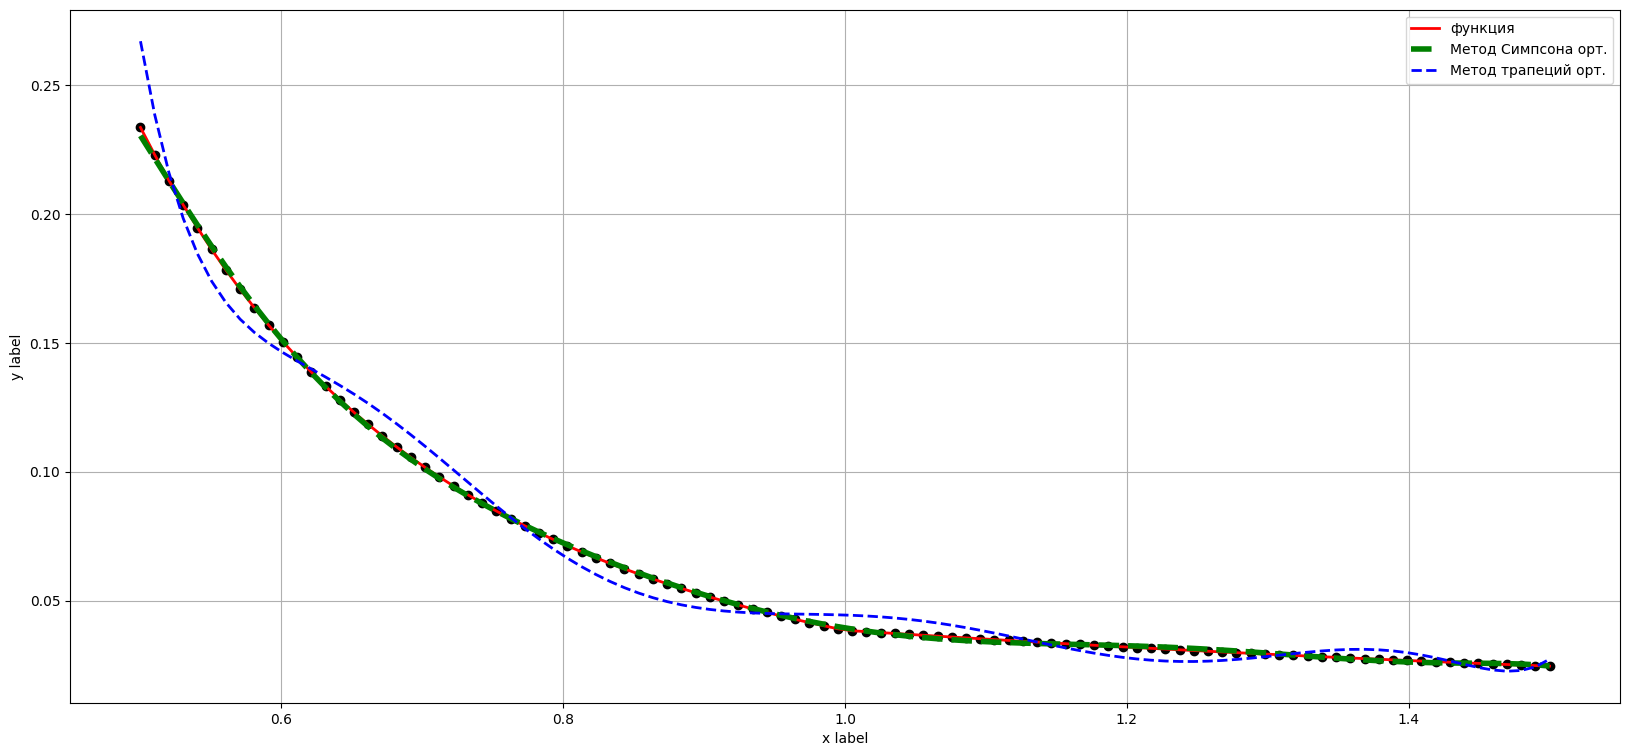

In [17]:
main2(15, 10)
main2(15, 50)
main2(15, 100)

Time exec for ort: 0.008148431777954102 by trap
Time exec for ort: 0.008598804473876953 by sym


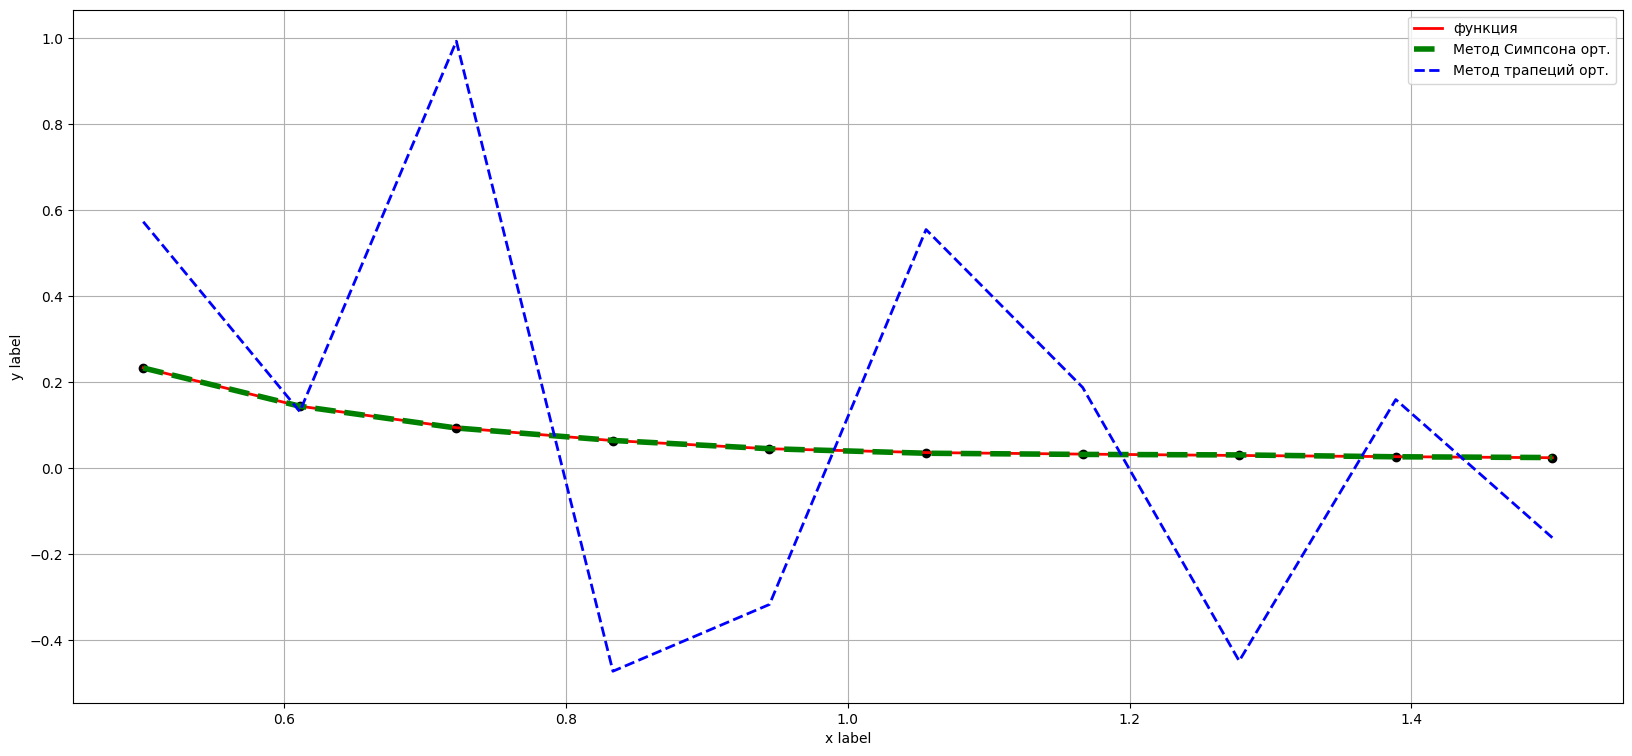

Time exec for ort: 0.012611627578735352 by trap
Time exec for ort: 0.01109766960144043 by sym


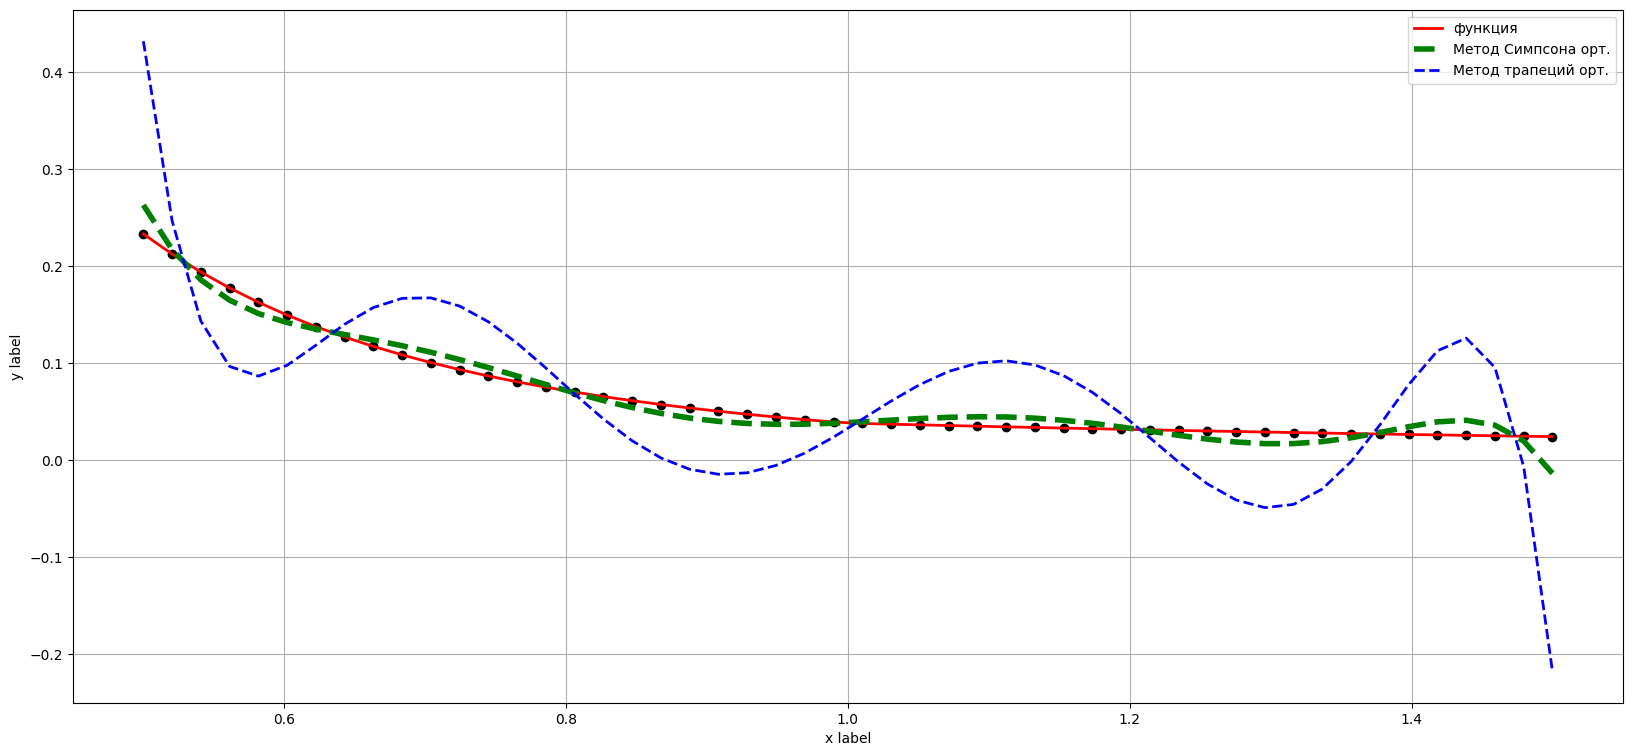

Time exec for ort: 0.013307332992553711 by trap
Time exec for ort: 0.013735532760620117 by sym


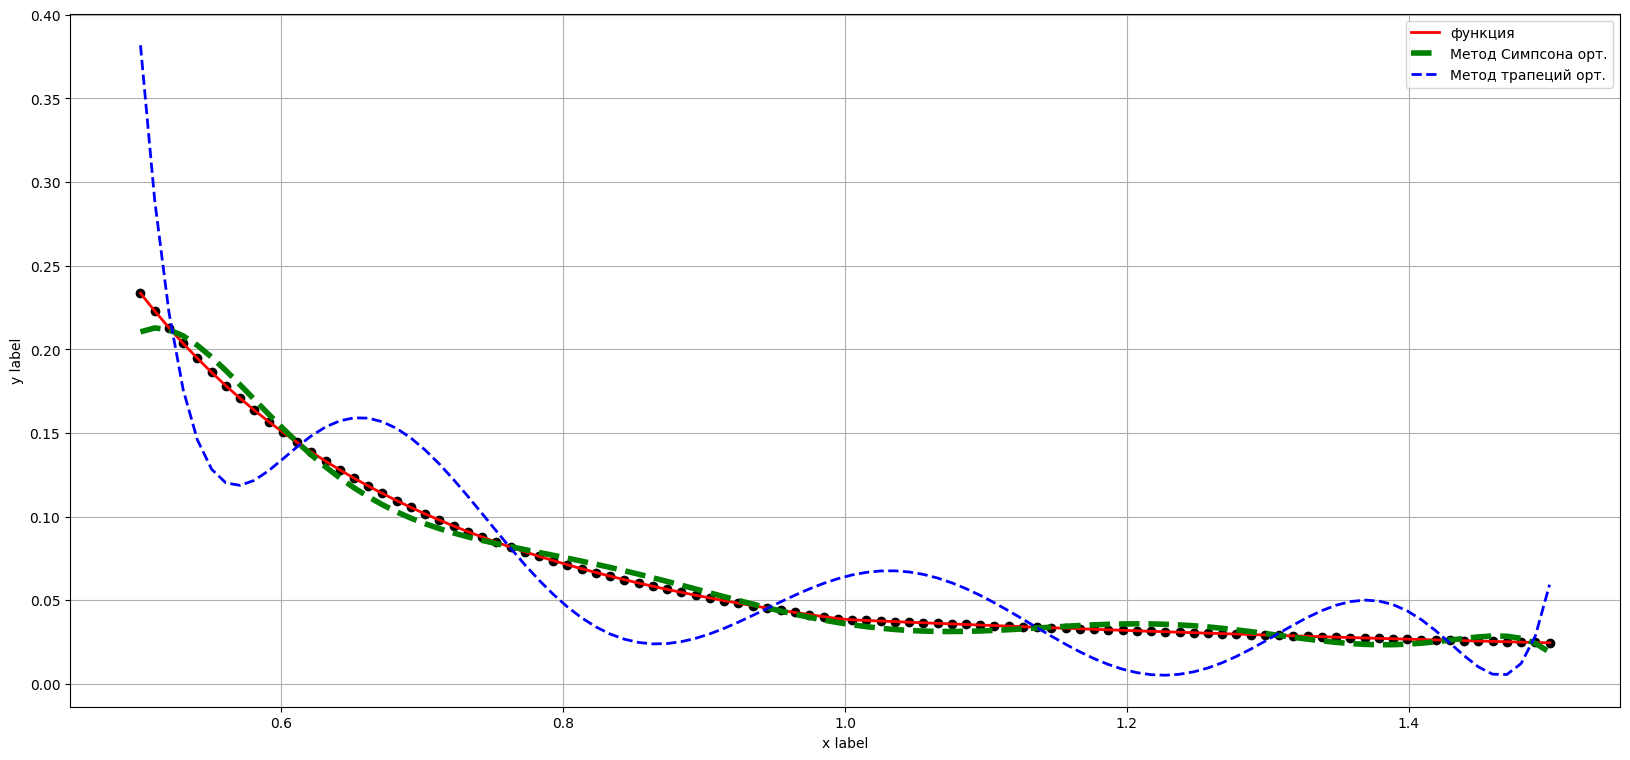

In [18]:
main2(50, 10)
main2(50, 50)
main2(50, 100)